In [30]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cv
import pandas as pd

# Analysis of txBurst datasets

So far we have focused on one dataset: "S33_c57_UMIs_concat", to develop methods for data analysis and inference. We now investigate the other datasets provided in the source, using the same methods produce results allowing for comparisons.

## SS3_c57_UMIs_concat_G1

In [31]:
# load in data
data_g1 = pd.read_csv("Data/SS3_c57_UMIs_concat_G1.csv", index_col="Unnamed: 0")
print(f"Size: {data_g1.shape}")
data_g1.head()

Size: (10727, 165)


,SS3_MAF_Leo171129_p2_S10,SS3_MAF_Leo171129_p2_S12,SS3_MAF_Leo171129_p2_S13,SS3_MAF_Leo171129_p2_S14,SS3_MAF_Leo171129_p2_S16,SS3_MAF_Leo171129_p2_S17,SS3_MAF_Leo171129_p2_S19,SS3_MAF_Leo171129_p2_S20,SS3_MAF_Leo171129_p2_S21,SS3_MAF_Leo171129_p2_S23,...,SS3_MAF_leo180223_p4_S179,SS3_MAF_leo180223_p4_S181,SS3_MAF_leo180223_p4_S183,SS3_MAF_leo180223_p4_S182,SS3_MAF_leo180223_p4_S185,SS3_MAF_leo180223_p4_S189,SS3_MAF_leo180223_p4_S188,SS3_MAF_leo180223_p4_S190,SS3_MAF_leo180223_p4_S98,SS3_MAF_leo180223_p4_S99
0610005C13Rik,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610007P14Rik,0.0,2.0,2.0,2.0,1.0,4.0,4.0,2.0,7.0,1.0,...,0.0,1.0,3.0,1.0,2.0,9.0,4.0,0.0,0.0,0.0
0610009B22Rik,10.0,4.0,NaN,NaN,0.0,14.0,6.0,2.0,11.0,4.0,...,0.0,2.0,1.0,6.0,14.0,0.0,1.0,4.0,3.0,2.0
0610009L18Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
0610009O20Rik,3.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,...,1.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


### Cleaning

First remove genes of mean expression < 1 (over non-missing values), and then those with significant numbers of missing values. There is unlikely to be enough information about these genes to find any meaningful results, so they can be discarded to reduce computation time.

In [32]:
# select rows with mean above 1
data_g1_2 = data_g1.loc[data_g1.mean(axis=1) > 1]
print(f"Size: {data_g1_2.shape}")

Size: (4123, 165)


Text(0.5, 0, 'Missing values in row')

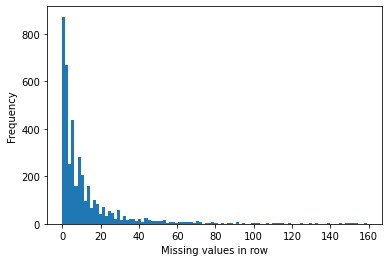

In [33]:
# find number of missing values per row
num_missing = data_g1_2.isna().sum(axis=1)
plt.hist(num_missing, bins=100);
plt.ylabel("Frequency")
plt.xlabel("Missing values in row")

In [34]:
num_missing[num_missing > 40].count()

298

The dataset has 165 columns (cells), so a row (gene) with more than 40 missing values has more than ~25% of the data missing, a significant proportion. There are only ~300 genes out of ~4000 with numbers of missing values above this threshold, so it is reasonable to remove them.

In [35]:
data_g1_cleaned = data_g1_2[data_g1_2.isna().sum(axis=1) < 40]
print(f"Size: {data_g1_cleaned.shape}")
data_g1_cleaned.head()

Size: (3815, 165)


,SS3_MAF_Leo171129_p2_S10,SS3_MAF_Leo171129_p2_S12,SS3_MAF_Leo171129_p2_S13,SS3_MAF_Leo171129_p2_S14,SS3_MAF_Leo171129_p2_S16,SS3_MAF_Leo171129_p2_S17,SS3_MAF_Leo171129_p2_S19,SS3_MAF_Leo171129_p2_S20,SS3_MAF_Leo171129_p2_S21,SS3_MAF_Leo171129_p2_S23,...,SS3_MAF_leo180223_p4_S179,SS3_MAF_leo180223_p4_S181,SS3_MAF_leo180223_p4_S183,SS3_MAF_leo180223_p4_S182,SS3_MAF_leo180223_p4_S185,SS3_MAF_leo180223_p4_S189,SS3_MAF_leo180223_p4_S188,SS3_MAF_leo180223_p4_S190,SS3_MAF_leo180223_p4_S98,SS3_MAF_leo180223_p4_S99
0610007P14Rik,0.0,2.0,2.0,2.0,1.0,4.0,4.0,2.0,7.0,1.0,...,0.0,1.0,3.0,1.0,2.0,9.0,4.0,0.0,0.0,0.0
0610009B22Rik,10.0,4.0,NaN,NaN,0.0,14.0,6.0,2.0,11.0,4.0,...,0.0,2.0,1.0,6.0,14.0,0.0,1.0,4.0,3.0,2.0
0610031J06Rik,17.0,18.0,9.0,14.0,0.0,9.0,22.0,10.0,12.0,21.0,...,11.0,2.0,4.0,18.0,8.0,31.0,15.0,1.0,1.0,2.0
0610037L13Rik,1.0,1.0,1.0,1.0,6.0,4.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0
1110007C09Rik,1.0,0.0,4.0,9.0,0.0,0.0,0.0,0.0,7.0,0.0,...,5.0,1.0,0.0,4.0,0.0,0.0,5.0,0.0,2.0,0.0


We are now left with 3815 genes which are deemed to have enough information present to be able to analyse. However, the cleaning process is very simple and does not remove all missing values so it is inevitable that some of these genes will not provide any results.

### Store data

In [24]:
data_g1_cleaned.to_csv("Data/SS3_c57_UMIs_concat_G1_cleaned.csv")

# Processing

We now use "processing_test.ipynb" to apply the processing pipeline to the dataset:

- load in dataset
- loop over genes, for each apply refined bounding method
- record solution dataset


# Solution Analysis

To understand the results we developed some summary statistics of the bound datasets in "data_categoization.ipynb". We now apply them to the bounds here:

In [41]:
bounds_g1 = pd.read_csv("Data/SS3_c57_UMIs_concat_G1_bounds_full.csv", index_col="Unnamed: 0")
print(f"Size = {bounds_g1.shape}")
bounds_g1.head()

Size = (3815, 265)


C:\Users\willi\AppData\Local\Temp\ipykernel_17664\1998444269.py:1: DtypeWarning: Columns (181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265) have mixed types. Specify dtype option on import or set low_memory=False.
  bounds_g1 = pd.read_csv("Data/SS3_c57_UMIs_concat_G1_bounds_full.csv", index_col="Unnamed: 0")


,k0,k1,mu_1,mu_2,mu_3,mu_4,mu_5,mu_6,mu_7,mu_8,...,mu_254,mu_255,mu_256,mu_257,mu_258,mu_259,mu_260,mu_261,mu_262,mu_263
0,1,"[0.549019607838504, 1.6333333333340467, 'optim...","[-4.968104868457716e-13, 1.0000000000004288, '...","[-9.071345439207027e-13, 1.000000000000344, 'o...","[-8.348545574642873e-13, 1.0000000000005451, '...","[-6.723589989210342e-13, 1.0000000000018152, '...","[-5.582507134799202e-13, 1.0000000000001046, '...","[-5.899905290245118e-13, 0.6555034606000919, '...","[-5.821991390502295e-13, 0.6555034605976956, '...","[-5.730035818375533e-13, 0.548082220829631, 'o...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"[0.7407407407319133, 2.3846153846185265, 'opti...","[-2.2624830660060497e-14, 1.0000000000011164, ...","[-1.3395350063123706e-14, 1.0000000000005183, ...","[-1.2383062173088052e-14, 1.000000000000361, '...","[-1.2535634533254295e-14, 1.000000000000261, '...","[-1.1750932614781395e-14, 0.853846153896769, '...","[-1.334200707300774e-14, 0.8538461538775591, '...","[-1.463678188079693e-14, 0.8538461538773282, '...","[-1.501337756405645e-14, 0.8538461538576455, '...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,"[0.19047619047462883, 2.400714285719468, 'opti...","[3.3155602668652115e-16, 0.9999999999999667, '...","[-2.929495559867368e-14, 0.9999999999999505, '...","[-3.2764124688859696e-16, 0.999999999999937, '...","[-3.425330599390488e-16, 0.9999999999999271, '...","[-3.4477446518902445e-16, 0.9999999999999553, ...","[-3.2185568295833293e-16, 0.9999999999999685, ...","[-3.784800466644851e-16, 0.9999999999999635, '...","[-3.764866181088108e-16, 0.9999999999999659, '...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,"[None, None, 'infeasible', 'infeasible']","[None, None, 'infeasible', 'infeasible']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,"[2.0412595005188154, 2.9436619718546386, 'opti...","[-2.3858852334048516e-13, 0.25742641930359084,...","[-1.3962035920676666e-13, 0.3067208399761192, ...","[-9.217319376230622e-14, 1.000000000004617, 'o...","[-9.518256107612031e-14, 1.000000000003932, 'o...","[-9.575383910031449e-14, 1.000000000003544, 'o...","[-9.17499402196626e-14, 1.0000000000056042, 'o...","[-9.275128429321251e-14, 1.0000000000000862, '...","[-9.30671249961835e-14, 1.0000000000000968, 'o...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
def summary_statistics(data):
    # boolean mask over k1 column: look for solution lists with infeasible in
    mask_infeasible = data.k1.apply(lambda x: 'infeasible' in x)
    # apply mask to select these rows
    infeasible_genes = data[mask_infeasible]
    # count number of genes
    inf_num = infeasible_genes.shape[0]
    inf_per = round(100 * inf_num / data.shape[0], 2)
    print(f"{inf_num} infeasible genes, {inf_per}% of the data.")

    # select feasible rows (~mask = logical not of mask)
    feasible_genes = data[~mask_infeasible]
    # count number of genes
    feas_num = feasible_genes.shape[0]
    feas_per = round(100 * feas_num / data.shape[0], 2)
    print(f"{feas_num} feasible genes, {feas_per}% of the data.")

    from ast import literal_eval

    def zero_lb(row):
        """Boolean indicator if all lower bounds ~ 0 (with a tolerance)"""
        # take mu_k columns: discard k0 and k1 columns
        row = row[2:]
        # loop over columns
        for bounds in row:
            # if not nan (not estimated)
            if pd.notnull(bounds):
                # convert string to list: take lower bound
                lb = literal_eval(bounds)[0]
                # if not None (infeasible, no bounds)
                if lb:
                    # if lb sufficiently large: return False (non-zero lb found)
                    if lb > 10**(-2):
                        return False
                # if None: infeasible, no bounds: question doesn't make sense
                else:
                    return np.nan
        # no sufficiently large lb: return True (all lb zero)
        return True

    # boolean mask of rows (of feasible genes)
    mask_zero = feasible_genes.apply(zero_lb, axis='columns')
    # apply mask
    zero_lb_genes = feasible_genes[mask_zero]
    # count number of genes
    zero_lb_num = zero_lb_genes.shape[0]
    zero_lb_per = round(100 * zero_lb_num / feas_num, 2)
    print(f"{zero_lb_num} genes with zero lower bounds, {zero_lb_per}% of the data.")
    # show
    zero_lb_genes.head()

    from ast import literal_eval

    def monotone_ub(row, decreasing=True):
        """
        Boolean indicator if upper bounds of dist. are montone (weakly)

        row: row of data containing lists of bounds on parameters + nan values
        decreasing:
            (True) return bool of whether upper bounds are weakly decreasing
            (False) return bool of whether upper bounds are weakly increasing
        """
        if decreasing:
            # arbitrary high value
            ub_prev = 10
        else:
            # arbitrarily low value
            ub_prev = -10
        # take mu_k columns: discard k0 and k1 columns
        row = row[2:]
        # loop over columns
        for bounds in row:
            # if not nan (not estimated)
            if pd.notnull(bounds):
                # convert string to list: take upper bound
                ub = literal_eval(bounds)[1]
                # if not None (infeasible, no bounds)
                if ub:
                    # decreasing ub: if ub > ub_prev, return False (not decreasing)
                    if ub > ub_prev and decreasing:
                        return False
                    # increasing ub: if ub < ub_prev, return False (not increasing)
                    elif ub < ub_prev and not decreasing:
                        return False
                    # otherwise, update ub_prev to new value
                    else:
                        ub_prev = ub
                # if None: infeasible, no bounds: question doesn't make sense
                else:
                    return np.nan
        # no problems found: return True
        return True

    # boolean mask of rows (of feasible genes)
    mask_dec = feasible_genes.apply(monotone_ub, args=(True,), axis='columns')
    mask_inc = feasible_genes.apply(monotone_ub, args=(False,), axis='columns')
    # apply mask
    dec_ub_genes = feasible_genes[mask_dec]
    inc_ub_genes = feasible_genes[mask_inc]
    # count number of genes
    dec_num = dec_ub_genes.shape[0]
    inc_num = inc_ub_genes.shape[0]
    dec_per = round(100 * dec_num / feas_num, 2)
    inc_per = round(100 * inc_num / feas_num, 2)
    print(f"{dec_num} genes with all decreasing upper bounds, {dec_per}% of the feasible data.")
    print(f"{inc_num} genes with all increasing upper bounds, {inc_per}% of the feasible data.")

    def average_width(row, threshold=0.5, bool=True):
        """
        Calculate average width of dist. interval bounds
        Return bool of average < threshold, or just average if bool = False
        """
        # take mu_k columns: discard k0 and k1 columns
        row = row[2:]
        widths = []
        # loop over columns
        for bounds in row:
            # if not nan (not estimated)
            if pd.notnull(bounds):
                # convert string to list: take upper bound
                bound = literal_eval(bounds)
                lb = bound[0]
                ub = bound[1]
                # if not None (infeasible, no bounds)
                if ub:
                    widths.append(ub - lb)
                # if None: infeasible, no bounds: question doesn't make sense
                else:
                    return np.nan
        avg = sum(widths) / len(widths)
        if bool:
            return avg < threshold
        else:
            return avg

    # boolean mask of rows (of feasible genes)
    threshold = 0.5
    mask_width = feasible_genes.apply(average_width, args=(threshold,), axis='columns')
    # apply mask
    tight_genes = feasible_genes[mask_width]
    # count number of genes
    tight_num = tight_genes.shape[0]
    tight_per = round(100 * tight_num / feas_num, 2)
    print(f"{tight_num} genes with average width < {threshold} , {tight_per}% of the feasible data.")

    # range of widths
    widths = [x/10 for x in range(0,12)]
    width_num = []
    # threshold based on each width
    for threshold in widths:
        mask_width = feasible_genes.apply(average_width, args=(threshold,), axis='columns')
        # apply mask
        tight_genes = feasible_genes[mask_width]
        # count number of genes
        tight_num = tight_genes.shape[0]
        tight_per = round(100 * tight_num / feas_num, 2)
        width_num.append(tight_per)
    # plot
    plt.step(widths, width_num)
    plt.title("Percentage of (feasible) genes with average solution width < threshold")
    plt.xlabel("Average width threshold")
    plt.ylabel("Percentage")
    plt.show()

    # average widths
    avg_width = feasible_genes.apply(average_width, args=(0.5, False), axis='columns')
    # histogram
    plt.hist(avg_width, bins=100, density=True)
    plt.xlabel("Average width of distribution bounds")
    plt.ylabel("Frequency")

146 infeasible genes, 3.83% of the data.
3669 feasible genes, 96.17% of the data.
3341 genes with zero lower bounds, 91.06% of the data.
184 genes with all decreasing upper bounds, 5.01% of the feasible data.
193 genes with all increasing upper bounds, 5.26% of the feasible data.
156 genes with average width < 0.5 , 4.25% of the feasible data.


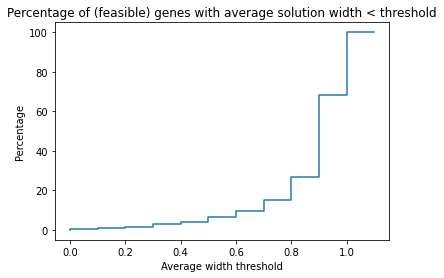

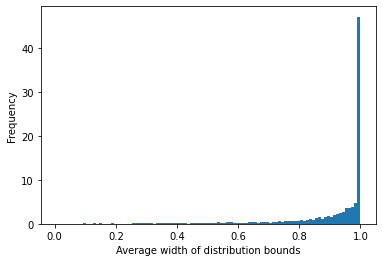

In [43]:
summary_statistics(bounds_g1)